In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import *
import pyomo.environ as pe


In [2]:
# functions to be used for calculations, plotting, etc.

def ent_rate_memory_exact(p_list,W):
    # calculates the e2e rate of a path with a list of success prob
    # and W memories
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])

def ent_rate_memory_gaussian(p_list,W, Wmax = 100):
    N = len(p_list)
    Q = np.zeros((Wmax,N))
    P = np.zeros((Wmax,N))
    for k in range(N):
        p_k = p_list[k]
        for i in range(Wmax):
            Q[i,k] = gauessian_dist(i+1,W*p_k,sqrt(W*p_k*(1-p_k))) 
            
    P[:,0] = Q[:,0]
    for k in range(1,N):
        for i in range(Wmax):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1]) 
    return np.sum(np.arange(1,Wmax+1)*P[:,-1])


def binomial_dist(i,W,p_k):
    return comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

def gaussian_dist(x,μ,σ):
    return 1/(σ*sqrt(2*pi))*np.exp(-(x-μ)**2/σ**2/2)

def pe_gaussian_dist(x,μ,σ):
    return 1/(σ*pe.sqrt(2*pi))*pe.exp(-(x-μ)**2/σ**2/2)


def ent_calc_x(user_pair,x_opt,w_opt,Wmax = 100,gaussian=True):
    num_nodes = len(R_list)
    Q = np.zeros((Wmax,2+num_nodes**2))
    P = np.zeros(Wmax)

    t = t_list[user_pair]
         
    for i in range(Wmax):
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            if gaussian:
                Q[i,0] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
                P[i] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
            else:
                Q[i,0] += x_opt[user_pair,s,n1]*binomial_dist(i,w_opt,p_k) 
                P[i] += x_opt[user_pair,s,n1]*binomial_dist(i,w_opt,p_k) 
                
    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            k = i1*num_nodes+i2+1
            if n2 != n1:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                for i in range(Wmax):
                    if gaussian:
                        Q[i,k] = gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
                    else:
                        Q[i,k] = binomial_dist(i,w_opt,p_k) 
#     counter = 0 
#     for i1, n1 in enumerate(R_list):
#         for i2, n2 in enumerate(R_list):
#             for i in range(Wmax):
#                 P[i] = P[i]* (np.sum(Q[i:,counter+1])**x_opt[user_pair,n1,n2]) + x_opt[user_pair,n1,n2]*Q[i,counter+1]* np.sum(P[i+1:]) 
#             counter += 1
    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            k = i1*num_nodes+i2+1
            if n2!= n1:
                for i in range(Wmax):
                    P[i] = P[i]* (np.sum(Q[i:,k])**x_opt[user_pair,n1,n2]) + x_opt[user_pair,n1,n2]* Q[i][k] * np.sum(P[i+1:])      

    for n1 in R_list:
        p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
        for i in range(Wmax):
            if gaussian:
                Q[i,-1] += x_opt[user_pair,n1,t]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
            else:
                Q[i,-1] += x_opt[user_pair,n1,t]*binomial_dist(i,w_opt,p_k) 
    for i in range(Wmax):
        P[i] = P[i]* np.sum(Q[i:,-1])**np.sum( x_opt[user_pair,R_list,t]) + np.sum( x_opt[user_pair,R_list,t])* Q[i,-1]* np.sum(P[i+1:]) 
    return np.sum(np.arange(1,Wmax+1)*P)

def plot_output(x_opt,y_opt):
    plt.figure(figsize=(4,3))
    for i,y_val in enumerate(y_opt):
        if i not in np.concatenate((s_list,t_list)):
            if y_val > 0.5:
                plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
                plt.text(pos[i][0],pos[i][1],"%d" % i)
            else:
                plt.plot(pos[i][0],pos[i][1],"bo")
                plt.text(pos[i][0],pos[i][1],"%d" % i)

    for e in G.edges():
        plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)
    colors = ["violet","orange","gray"]
    for user_pair in range(C):
        s = s_list[user_pair]
        plt.plot(pos[s][0],pos[s][1],"s", color = colors[user_pair])
        plt.text(pos[s][0],pos[s][1],"%d" % s)
        t = t_list[user_pair]
        plt.plot(pos[t][0],pos[t][1],"s", color = colors[user_pair])
        plt.text(pos[t][0],pos[t][1],"%d" % t)

        edges = np.argwhere(x_opt[user_pair,:,:]>0.5)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(list(e))
            else:
                path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                path_output.append(path)
                for i in range(len(path)-1):
                    e1 = path[i]
                    e2 = path[i+1]
                    plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

        print((s_list[user_pair],t_list[user_pair]),":",path_output)
#     plt.xlim([0,L0])
#     plt.xlim([0,L0])
    plt.show()
    


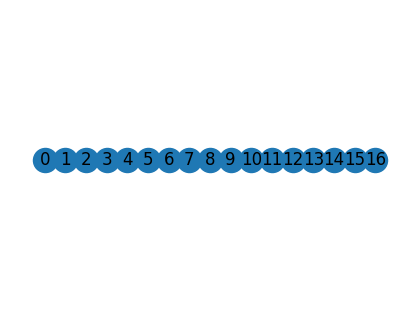

In [698]:
# network graph
N = 17# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 13.88
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat += adj_mat.T

pos = dict()
for node in range(N):
    pos[node] = (p*node,0)
    
G = nx.from_numpy_array(adj_mat)
plt.figure(figsize=(4,3))
nx.draw(G, pos = pos,  with_labels=True)
plt.show()


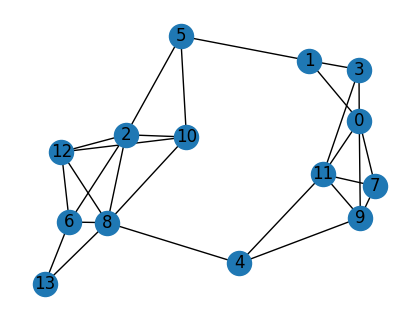

In [12]:
# random network graph of N nodes
N = 14# number of nodes
node_list = np.arange(N)

# nodes are distributed uniformly within an L0xL0 square
L0 = 100 # square dim in km
length = L0
width = L0
# dmax = 0.35*L0 # cut off for elementary links
# random.seed(33)
dmax = 0.4*L0
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

## pyomo implementation of LP
multiuser, one memory per (s,d)

In [13]:

Nmax = 10
Lmax = 51
D0 = 2
D = D0*np.ones(N)
s_list = [0] # source
t_list = [2] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.matrix = pe.Set(initialize=model.C*model.N*model.N)
model.x = pe.Var(model.matrix, domain=pe.Binary)
model.y = pe.Var(model.N, domain=pe.Binary)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    model.constraints.add( nx.shortest_path_length(G, source=s, target=t, weight="weight")*model.x[user_pair,s,t] <= Lmax)    
    
    number = 0
#     path_s = model.x[user_pair,s,t]
#     path_t = model.x[user_pair,s,t]
    for n1 in R_list:
        
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            model.constraints.add( l_uv* model.x[user_pair,s,n1] <= Lmax)
            path_length += l_uv*  model.x[user_pair,s,n1]
        else:
            model.constraints.add(  model.x[user_pair,s,n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            model.constraints.add( l_uv* model.x[user_pair,n1,t] <= Lmax)        
            path_length += l_uv* model.x[user_pair,n1,t]
        else:
            model.constraints.add( model.x[user_pair,n1,t] == 0 ) 

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        number += model.x[user_pair,s,n1]+ model.x[user_pair,n1,t]
#         path_s += model.x[user_pair,s,n1]
#         path_t += model.x[user_pair,n1,t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    model.constraints.add( l_uv* model.x[user_pair,n1,n2] <= Lmax)
                    path_length += l_uv* model.x[user_pair,n1,n2]
                else:
                    model.constraints.add( model.x[user_pair,n1,n2] == 0 ) 
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
                number += model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
    model.constraints.add( number <= Nmax ) 
#     model.constraints.add( path_s == 1 )
#     model.constraints.add( path_t == 1 )
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)


# y_sum = 0
# for n1 in range(N):
#     if (n1 not in s_list) and (n1 not in t_list):
#         y_sum += model.y[n1]
model.objective = pe.Objective(expr=sum( model.y[i] for i in model.R), sense=pe.minimize)

# model.objective = pe.Objective(expr=y_sum, sense=minimize)
# pe.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt') 
opt = pe.SolverFactory("baron")
results = opt.solve(model, tee=True)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = model.y[i].value
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



 BARON version 23.4.28. Built: OSX-64 Fri Apr 28 09:08:04 EDT 2023

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Hassan Shapourian at Cisco Systems, Inc., hshapour@cisco.com.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Preprocessing found feasible solution with value 2.00000
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             0             0.04      2.00000          2.

(0, 2) : [[0, 1], [1, 5], [5, 2]]


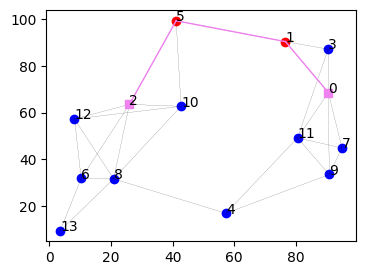

No. of memories in repeaters:
[nan  1. nan  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True :   2.0


In [14]:
plot_output(x_opt,y_opt)

print("No. of memories in repeaters:")
print(y_opt)
model.objective.display()


## pyomo implementation of MINLP
multiuser, w memory per (s,d) is a decision variable

In [20]:

Nmax = 10
Lmax = 41
D0 = 4
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
# model.matrix = pe.Set(initialize=model.C*model.N*model.N)
model.matrix = model.C*model.N*model.N
model.x = pe.Var(model.matrix, domain=pe.Binary,initialize=0)#,intitialize={(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}, default=0)
model.y = pe.Var(model.R, domain=pe.Binary,initialize=0)
model.w = pe.Var(model.C, domain=pe.PositiveIntegers,initialize=1)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.w[user_pair]*model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.w[user_pair]*model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     model.constraints.add( nx.shortest_path_length(G, source=s, target=t, weight="weight")*model.x[user_pair,s,t] <= Lmax)    
    
#     number = 0
#     path_s = model.x[user_pair,s,t]
#     path_t = model.x[user_pair,s,t]
    for n1 in R_list:
        
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,s,n1] <= Lmax)
#             path_length += l_uv*  model.x[user_pair,s,n1]
        else:
            model.constraints.add(  model.x[user_pair,s,n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,n1,t] <= Lmax)        
#             path_length += l_uv* model.x[user_pair,n1,t]
        else:
            model.constraints.add( model.x[user_pair,n1,t] == 0 ) 

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
#         number += model.x[user_pair,s,n1]+ model.x[user_pair,n1,t]
#         path_s += model.x[user_pair,s,n1]
#         path_t += model.x[user_pair,n1,t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
#                     model.constraints.add( l_uv* model.x[user_pair,n1,n2] <= Lmax)
#                     path_length += l_uv* model.x[user_pair,n1,n2]
                else:
                    model.constraints.add( model.x[user_pair,n1,n2] == 0 ) 
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
#                 number += model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
#     model.constraints.add( number <= Nmax ) 
#     model.constraints.add( path_s == 1 )
#     model.constraints.add( path_t == 1 )
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############

# path_prob = []
# # path_prob = np.array([[0]*N]*N).tolist()
# for user_pair in range(C):
#     for n1 in range(N):
#         for n2 in range(N):
#             p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
# #             path_prob[n1][n2]= pe.Expr_if(IF=model.x[user_pair,n1,n2]>0, THEN=p_k, ELSE=0)
#             pe.Expr_if(IF=model.x[user_pair,n1,n2]>0, THEN=path_prob.append(p_k), ELSE=0)

# def ObjRule(model):
path_length = 0        
model.number = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    model.number +=  sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
    for n1 in R_list:        
        n_list = np.array(list(set(R_list)-{n1}))
        model.number += sum(model.x[user_pair,n1,i] for i in n_list)

        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
#                 model.constraints.add( l_uv* model.x[user_pair,s,n1] <= Lmax)
            path_length += l_uv*  model.x[user_pair,s,n1]
#             else:
#                 model.constraints.add(  model.x[user_pair,s,n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
#                 model.constraints.add( l_uv* model.x[user_pair,n1,t] <= Lmax)        
            path_length += l_uv* model.x[user_pair,n1,t]
#             else:
#                 model.constraints.add( model.x[user_pair,n1,t] == 0 ) 
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
#                         model.constraints.add( l_uv* model.x[user_pair,n1,n2] <= Lmax)
                    path_length += l_uv* model.x[user_pair,n1,n2]
#                     else:
#                         model.constraints.add( model.x[user_pair,n1,n2] == 0 ) 

#     print(pe.value(number))
#     return pe.Expression(expr = number)
#     model.constraints.add( number <= Nmax ) 

#     num_nodes = len(R_list)
#     Wmax = 10
#     q_size = 2+num_nodes**2
#     Q = np.array([[0]*q_size]*Wmax).tolist()
#     # P = np.array([[0]*q_size]*Wmax).tolist()
#     P = [None]*Wmax
#     rate = 0 #[None]*C
#     for user_pair in range(C):
#         s = s_list[user_pair]
#         t = t_list[user_pair]

#         for i in range(Wmax):
#             q_sum = 0
#             for n1 in (list(R_list)+ [t]):
#                 p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
#                 q_sum += model.x[user_pair,s,n1]*pe_gaussian_dist(i+1,model.w[user_pair]*p_k,pe.sqrt(model.w[user_pair]*p_k*(1-p_k))) 
#     #         Q[i][0] =  q_sum 
#             P[i] = q_sum 

#         for i1, n1 in enumerate(R_list):
#             for i2, n2 in enumerate(R_list):
#                 if n2 != n1:
#                     p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
#                     for i in range(Wmax):
#                         Q[i][i1*num_nodes+i2+1]  = pe_gaussian_dist(i+1,model.w[user_pair]*p_k,pe.sqrt(model.w[user_pair]*p_k*(1-p_k))) 

#         counter = 0 
#         for i1, n1 in enumerate(R_list):
#             for i2, n2 in enumerate(R_list):
#                 k = i1*num_nodes+i2+1
#                 if n2!= n1:
#                     for i in range(Wmax):
#     #                     P[i][counter+1] = P[i][counter]* (np.sum(np.array(Q)[i:,counter+1])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][counter+1] * np.sum(np.array(P)[i+1:,counter])      
#     #                     P[i][counter+1] = P[i][counter]* (np.sum(np.array(Q)[i:,k])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][k] * np.sum(np.array(P)[i+1:,counter])      
#                         P[i] = P[i]* (np.sum(np.array(Q)[i:,k])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][k] * np.sum(P[i+1:])      
#                     counter += 1

#         for i in range(Wmax):
#             q_sum = 0
#             for n1 in R_list:
#                 p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
#                 q_sum  += model.x[user_pair,n1,t]*pe_gaussian_dist(i+1,model.w[user_pair]*p_k,pe.sqrt(model.w[user_pair]*p_k*(1-p_k))) 
#             Q[i][-1] =  q_sum 

#         t_sum = sum(model.x[user_pair,i,t] for i in model.R)
#         for i in range(Wmax):
#             P[i] = P[i]* np.sum(np.array(Q)[i:,-1])**t_sum + t_sum* Q[i][-1]* np.sum(P[i+1:]) 
#         rate += np.sum(np.arange(1,Wmax+1)*P )  
#     print(pe.value(rate))
#     return rate

# # model.objective = pe.Objective(expr=ent_calc_x(user_pair,model.x,model.w[user_pair],Wmax = 10) , sense=pe.maximize)

# #############
# def pe_ent_rate_memory_gaussian(p_list,W, Wmax = 100):
#     N = len(p_list)
#     print(N)
# #     Q = np.zeros((Wmax,N))
# #     P = np.zeros((Wmax,N))
#     Q = np.array([[0]*N]*Wmax).tolist()
#     P = np.array([[0]*N]*Wmax).tolist()
#     for k in range(N):
#         p_k = p_list[k]
#         for i in range(Wmax):
#             Q[i][k] = pe_gaussian_dist(i+1,W*p_k,pe.sqrt(W*p_k*(1-p_k))) 
#             if k==0:
#                 P[i][k] = Q[i][k]
                
#     for k in range(1,N):
#         for i in range(Wmax):
#             P[i][k] = P[i][k-1]* np.sum(np.array(Q)[i:,k]) + Q[i][k]* np.sum(np.array(P)[i+1:,k-1]) 
#     return np.sum(np.arange(1,Wmax+1)*np.array(P)[:,-1])

# rate = [None]*C
# for user_pair in range(C):
#     s = s_list[user_pair]
#     t = t_list[user_pair]
#     path_prob = []
#     for e1 in range(N):
#         for e2 in range(N):
#             if e2 != e1:
#                 if pe.value(model.x[user_pair,e1,e2]) >0:
#                     path_prob.append(10**(-0.2*nx.shortest_path_length(G, source=e1, target=e2, weight="weight")/10) )


#     rate[user_pair] = pe.Expression( pe_ent_rate_memory_gaussian(path_prob, model.w[user_pair], Wmax = 10) )
#################
# model.constraints.add(expr= sum(model.y[i] for i in model.R) <= 2)
model.objective = pe.Objective(expr= sum( model.y[i] for i in model.R), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum( pe.log(model.w[i]) for i in model.C), sense=pe.maximize)
# α = 0.1
# model.objective = pe.Objective(expr= sum(model.y[i] for i in model.R)+ 2*α*path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum(pe.log(rate[i]) for i in range(C)), sense=pe.maximize)

# model.objective = pe.Objective(rule=ObjRule, sense=pe.minimize)
# model.objective = pe.Objective(expr= 1/(model.number) , sense=pe.minimize)

# model.objective = pe.Objective(expr=y_sum, sense=minimize)
# results = pe.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt') 
# opt = pe.SolverFactory('mindtpy')
opt = pe.SolverFactory("baron",tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



ValueError: Cannot load a SolverResults object with bad status: aborted

In [255]:

Nmax = 10
# Lmax = 41
D0 = 2
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination
# s_list = [10,12,13] # source
# t_list = [7,11,9] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
# model.matrix = pe.Set(initialize=model.C*model.N*model.N)
model.matrix = model.C*model.N*model.N
model.x = pe.Var(model.matrix, domain=pe.Binary)#,initialize=0)#,intitialize={(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}, default=0)
model.y = pe.Var(model.R, domain=pe.Binary)#,initialize=0)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     model.constraints.add( nx.shortest_path_length(G, source=s, target=t, weight="weight")*model.x[user_pair,s,t] <= Lmax)    
    
#     number = 0
#     path_s = model.x[user_pair,s,t]
#     path_t = model.x[user_pair,s,t]
    for n1 in R_list:
        
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,s,n1] <= Lmax)
#             path_length += l_uv*  model.x[user_pair,s,n1]
        else:
            model.constraints.add(  model.x[user_pair,s,n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,n1,t] <= Lmax)        
#             path_length += l_uv* model.x[user_pair,n1,t]
        else:
            model.constraints.add( model.x[user_pair,n1,t] == 0 ) 

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
#         number += model.x[user_pair,s,n1]+ model.x[user_pair,n1,t]
#         path_s += model.x[user_pair,s,n1]
#         path_t += model.x[user_pair,n1,t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
#                     model.constraints.add( l_uv* model.x[user_pair,n1,n2] <= Lmax)
#                     path_length += l_uv* model.x[user_pair,n1,n2]
                else:
                    model.constraints.add( model.x[user_pair,n1,n2] == 0 ) 
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
#                 number += model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
#     model.constraints.add( number <= Nmax ) 
#     model.constraints.add( path_s == 1 )
#     model.constraints.add( path_t == 1 )
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############

def ObjRule(model):
    M = 10
    F = 0.83
    rate = 1
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)

        rate_user = 1
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            rate *= (1-(1-p_k)**M)**model.x[user_pair,s,n1] 
#             rate = min(rate, p_k**model.x[user_pair,s,n1])  
#             rate_user = pe.Expr_if(IF=p_k**model.x[user_pair,s,n1]>rate_user, THEN=rate_user, ELSE=p_k)

            
        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                if n2 != n1:
                    p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                    rate *= (1-(1-p_k)**M)**model.x[user_pair,n1,n2] 
#                     rate = min(rate, p_k**model.x[user_pair,n1,n2])                    
#                     rate_user = pe.Expr_if(IF=p_k**model.x[user_pair,n1,n2]>rate_user, THEN=rate_user, ELSE=p_k)

        for n1 in R_list:
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
            rate *= (1-(1-p_k)**M)**model.x[user_pair,n1,t] 
#             rate = min(rate, p_k**model.x[user_pair,n1,t])                    
#             rate_user = pe.Expr_if(IF=p_k**model.x[user_pair,n1,t]>rate_user, THEN=rate_user, ELSE=p_k)
#         rate *= (rate_user*((1+3*((4*F-1)/3)**number)/4-0.5) )
        rate *= (rate_user*( 3*((4*F-1)/3)**number-1) )
    return pe.log(rate)

    # model.objective = pe.Objective(expr=ent_calc_x(user_pair,model.x,model.w[user_pair],Wmax = 10) , sense=pe.maximize)



    #################
# model.constraints.add(expr= sum(model.y[i] for i in model.R) <= 4)
# model.objective = pe.Objective(expr= sum( model.y[i] for i in model.R), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum( pe.log(model.w[i]) for i in model.C), sense=pe.maximize)
# α = 0.1
# model.objective = pe.Objective(expr= sum(model.y[i] for i in model.R)+ 2*α*path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum(pe.log(rate[i]) for i in range(C)), sense=pe.maximize)

model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)
# model.objective = pe.Objective(expr= 1/(number) , sense=pe.minimize)

# model.objective = pe.Objective(expr=y_sum, sense=minimize)
# results = pe.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt') 
# opt = pe.SolverFactory('mindtpy')
opt = pe.SolverFactory("baron",tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: problem
  Lower bound: -2.83370194345
  Upper bound: -2.83369910975
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 17
  Sense: unknown
  Missing bounds: 0
  Iterations: 5
  Node opt: 2
  Node memmax: 2
  Cpu time: 0.05
  Wall time: 0.06
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 0.09449195861816406
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------------------------------

(0, 4) : [[0, 1], [1, 2], [2, 3, 4]]


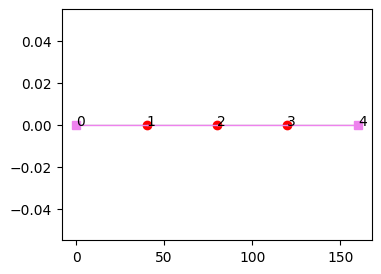

[0. 1. 1. 1. 0.]
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -2.8337019434515187


In [256]:
plot_output(x_opt,y_opt)       
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
print(y_opt)#, pe.value(rate[0]))
# print(path_prob)
model.objective.display()


In [375]:
# pe.value(model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) )
# pe.value(ObjRule(model))
# # for j in range(q_size):
# for i in range(Wmax):
#     print(pe.value(P[i]))

# for j in range(q_size):
#     for i in range(Wmax):
#         print(pe.value(Q[i][j]))
# print(x_opt[0,5,3])

vec = dict()
for i1 in range(N):
    for i2 in range(N):
        if i2 == i1+1:
            vec[(0,i1,i2)]=1
        else:
            vec[(0,i1,i2)]=0
# vec[(0,0,2)] = 1
# vec[(0,2,4)] = 1
# print(vec)
# {(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}


In [450]:

Nmax = 10
w = 2
# Lmax = 41
D0 = w
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
# model.matrix = pe.Set(initialize=model.C*model.N*model.N)
# model.matrix = model.C*model.N*model.N
# vec = {(0, 0, 1):1, (0, 1, 2):1, (0, 2, 3):1}
model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary)#,initialize=vec)
# model.nonz_positions = pe.Set(within=model.matrix, initialize=vec.keys())   # use of "within" will error-check
# model.x = pe.Param(model.low_positions, initialize=limit_positions)
# x0 = np.zeros((1,N,N))
# x0[0,:,:] =np.diag(np.ones(N-1),1)
# model.x = pe.Var(model.matrix, domain=pe.Binary,initialize=x0)#,intitialize=vec.keys(), default=0)
model.y = pe.Var(model.R, domain=pe.Binary)#,initialize=0)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     model.constraints.add( nx.shortest_path_length(G, source=s, target=t, weight="weight")*model.x[user_pair,s,t] <= Lmax)    
    
#     number = 0
#     path_s = model.x[user_pair,s,t]
#     path_t = model.x[user_pair,s,t]
    for n1 in range(N):
        model.constraints.add(  model.x[user_pair,n1,n1] == 0 ) 
        model.constraints.add(  model.x[user_pair,n1,s] == 0 ) 
        model.constraints.add(  model.x[user_pair,t,n1] == 0 ) 

    for n1 in R_list:
        
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,s,n1] <= Lmax)
#             path_length += l_uv*  model.x[user_pair,s,n1]
        else:
            model.constraints.add(  model.x[user_pair,s,n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
#             model.constraints.add( l_uv* model.x[user_pair,n1,t] <= Lmax)        
#             path_length += l_uv* model.x[user_pair,n1,t]
        else:
            model.constraints.add( model.x[user_pair,n1,t] == 0 ) 

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
#         number += model.x[user_pair,s,n1]+ model.x[user_pair,n1,t]
#         path_s += model.x[user_pair,s,n1]
#         path_t += model.x[user_pair,n1,t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
#                     model.constraints.add( l_uv* model.x[user_pair,n1,n2] <= Lmax)
#                     path_length += l_uv* model.x[user_pair,n1,n2]
                else:
                    model.constraints.add( model.x[user_pair,n1,n2] == 0 ) 
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
#                 number += model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
#     model.constraints.add( number <= Nmax ) 
#     model.constraints.add( path_s == 1 )
#     model.constraints.add( path_t == 1 )
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

#############
F = 0.9
def ObjRule(model):
    Wmax = w
    num_nodes = len(R_list)
    q_size = 2+num_nodes**2
    Q = np.array([[0]*q_size]*Wmax).tolist()
#     P = [None]*Wmax
    P = [0]*Wmax
    rate = 1 #[None]*C
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)

        for i in range(Wmax):
            q_sum = 0
            for n1 in (list(R_list)+ [t]):
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
#                 q_sum += model.x[user_pair,s,n1]*gaussian_dist(i+1,w*p_k,sqrt(w*p_k*(1-p_k))) 
                q_sum += model.x[user_pair,s,n1]*binomial_dist(i,w,p_k) 
            P[i] = q_sum 

        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                k = i1*num_nodes+i2+1
                if n2 != n1:
                    p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                    for i in range(Wmax):
#                         Q[i][k]  = gaussian_dist(i+1,w*p_k,sqrt(w*p_k*(1-p_k))) 
                        Q[i][k]  = binomial_dist(i,w,p_k)  
#         counter = 0 
        for i1, n1 in enumerate(R_list):
            for i2, n2 in enumerate(R_list):
                k = i1*num_nodes+i2+1
                if n2!= n1:
                    for i in range(Wmax):
                        P[i] = P[i]* (np.sum(np.array(Q)[i:,k])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][k] * np.sum(P[i+1:])      
#                         P[i] = P[i]* (np.sum(np.array(Q)[i:,counter+1])**model.x[user_pair,n1,n2]) + model.x[user_pair,n1,n2]* Q[i][counter+1] * np.sum(P[i+1:])      
#                 counter += 1

        for i in range(Wmax):
            q_sum = 0
            for n1 in R_list:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
#                 q_sum  += model.x[user_pair,n1,t]*gaussian_dist(i+1,w*p_k,pe.sqrt(w*p_k*(1-p_k))) 
                q_sum  += model.x[user_pair,n1,t]*binomial_dist(i,w,p_k)
            Q[i][-1] =  q_sum 

        t_sum = sum(model.x[user_pair,i,t] for i in model.R)
        for i in range(Wmax):
            P[i] = P[i]* np.sum(np.array(Q)[i:,-1])**t_sum + t_sum* Q[i][-1]* np.sum(P[i+1:]) 
            
#             P[i]= pe.Expr_if(IF=t_sum>0, THEN= P[i]* np.sum(np.array(Q)[i:,-1]) + Q[i][-1]* np.sum(P[i+1:]) 
# , ELSE= P[i])

#         rate *= ( ( 3*((4*F-1)/3)**number- 1)*np.sum(np.arange(1,Wmax+1)*P )  )
        rate *= np.sum(np.arange(1,Wmax+1)*P )  
#     print(pe.value(number), pe.value(rate))
    α = 0.1
    return (rate)#-α*path_length
#     return ( 3*((4*F-1)/3)**number- 1)

    # model.objective = pe.Objective(expr=ent_calc_x(user_pair,model.x,model.w[user_pair],Wmax = 10) , sense=pe.maximize)

def ObjRule2(model):
    return (0.3221693555911658*model.x[0,0,1] + 0.00018048823382181564*model.x[0,0,2])*0**model.x[0,1,1]*(0.3221693555911658*x[0,1,2] + 0.00381897489438407*x[0,1,2])**x[0,1,2] + x[0,1,2]*(0.3221693555911658*x[0,1,2])*((0.00381897489438407*x[0,0,1] + 2.5155848977401673e-17*x[0,0,2])*0**x[0,1,1]) + 2*((0.00381897489438407*x[0,0,1] + 2.5155848977401673e-17*x[0,0,2])*0**x[0,1,1]*(0.00381897489438407*x[0,1,2])**x[0,1,2])
    #################
# model.constraints.add(expr= sum(model.y[i] for i in model.R) <= 1)
# model.objective = pe.Objective(expr= sum( model.y[i] for i in model.R), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum( pe.log(model.w[i]) for i in model.C), sense=pe.maximize)
# α = 0.1
# model.objective = pe.Objective(expr= sum(model.y[i] for i in model.R)+ 2*α*path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= path_length - α*sum( pe.log(model.w[i]) for i in model.C), sense=pe.minimize)
# model.objective = pe.Objective(expr= sum(pe.log(rate[i]) for i in range(C)), sense=pe.maximize)

model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)
# model.objective = pe.Objective(expr= 1/(number) , sense=pe.minimize)

# model.objective = pe.Objective(expr=y_sum, sense=minimize)
# results = pe.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt') 
# opt = pe.SolverFactory('mindtpy')
# opt = pe.SolverFactory("bonmin",options={'bonmin.num_retry_unsolved_random_point' : 10}, tee=True)
opt = pe.SolverFactory("baron",options={'NumLoc' : -1, 'thread' : 4}, tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: problem
  Lower bound: 0.318208855322
  Upper bound: 0.323678867214
  Number of objectives: 1
  Number of constraints: 19
  Number of variables: 19
  Sense: unknown
  Missing bounds: -1
  Iterations: -1
  Node opt: -1
  Node memmax: 0
  Cpu time: 500.0
  Wall time: 503.41
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: maxTimeLimit
  Error rc: 0
  Time: 503.4460642337799
# ----------------------------------------------------------
#   Solution Information
# -----------------------------------------------

(0, 3) : [[0, 1], [1, 2, 3]]


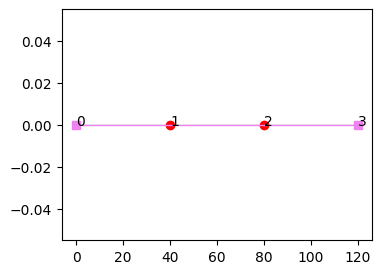

[0. 1. 1. 0.]
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.014494070000660685
0.014494070000660685
0.02487708551051746


In [451]:
plot_output(x_opt,y_opt)       
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
print(y_opt)#, pe.value(rate[0]))
# print(path_prob)
# print(pe.value(ObjRule(model)))
model.objective.display()
f_e2e = lambda x: ( 3*((4*F-1)/3)**x- 1)
print(ent_calc_x(0,x_opt,w,Wmax = w,gaussian=False))#*f_e2e(3))

x0 = np.zeros((1,N,N))
x0[0,:,:] =np.diag(np.ones(N-1),1)
# x0[0,0,3] = 1
# x0[0,2,4] = 1
# print(x0)
print(ent_calc_x(0,x0,w,Wmax = w,gaussian=False))#*f_e2e(N-1))


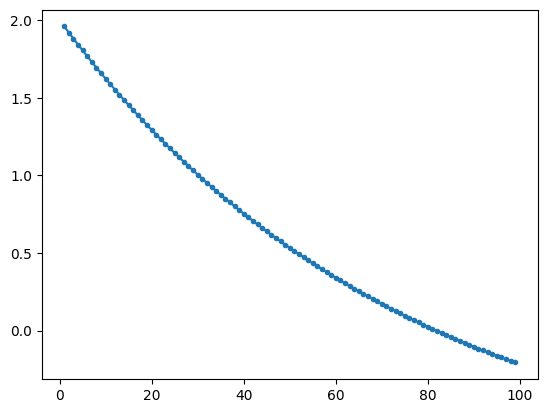

In [709]:
F = 0.99
f_e2e = lambda x: ( 3*((4*F-1)/3)**x- 1)
Nf = 100
fidelity_list =[]
for n in range(1,Nf):
    fidelity_list.append(f_e2e(n))
plt.plot(list(range(1,Nf)),fidelity_list,".-")

In [137]:
x0 = np.zeros((1,N,N))
# x0[0,0,4]= 1
# x0[0,:,:] =np.diag(np.ones(N-1),1)
x0[0,0,2] = 1
x0[0,2,4] = 1

e2e_rate_opt = np.zeros(C)
agg_rate = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
#     agg_rate += rate[user_pair][0] 

    w_opt = w
    s = s_list[user_pair]
#     edges = np.argwhere(x_opt[user_pair,:,:]>0)
    edges = np.argwhere(x0[user_pair,:,:]>0)
    path_prob = []
    path_dist = []
    path_output = []
    for e in edges:
        path_prob.append(10**(-0.2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
        path_dist.append( nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight") )
        if G.has_edge(e[0],e[1]):
            path_output.append(list(e))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
    print("gaussian matrix e2e:", ent_rate_memory_gaussian(path_prob,w_opt,Wmax=10))
#     print("exact val e2e rate:", np.log(ent_rate_memory_exact(path_prob,int(w_opt))))
#     print("-------------------")
#     e2e_rate_opt[user_pair], p_x = ent_calc_x(user_pair,x_opt,w_opt,Wmax=w)
#     print("gaussian x-based:", e2e_rate_opt[user_pair])
    print("gaussian x-based:", ent_calc_x(0,x0,w,Wmax = w))

# Sanity check: these two quantities have to be equal:
# print("agg e2e rate post process:", np.sum(np.log(e2e_rate_opt)))
# print("obj fn. (agg e2e rate) :", agg_rate)
# print("which nodes are repeaters: ", y_opt)

# model.pprint()


gaussian matrix e2e: 0.00018048823382186595
gaussian x-based: 0.00018048823382186595


## min approx

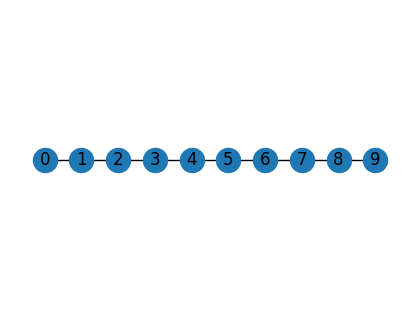

In [37]:
# network graph
N = 10# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 10
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat += adj_mat.T

pos = dict()
for node in range(N):
    pos[node] = (p*node,0)
    
G = nx.from_numpy_array(adj_mat)
plt.figure(figsize=(4,3))
nx.draw(G, pos = pos,  with_labels=True)
plt.show()


In [16]:
### minimum capacity

Nmax = 2
F = 0.95
w = 1
D0 = 3*w
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination
# s_list = [10,12,13] # source
# t_list = [7,11,9] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary)#,initialize=0)
model.y = pe.Var(model.R, domain=pe.Binary)#,initialize=1)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += w*model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for n1 in range(N):
        model.constraints.add(  model.x[user_pair,n1,n1] == 0 ) 
        model.constraints.add(  model.x[user_pair,n1,s] == 0 ) 
        model.constraints.add(  model.x[user_pair,t,n1] == 0 ) 

    for n1 in R_list:

        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            path_length += l_uv*  model.x[user_pair,s,n1]

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            path_length += l_uv* model.x[user_pair,n1,t]

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        for n2 in R_list:
            if n2 != n1:
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    path_length += l_uv* model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

        

###########
model.minCapacity = pe.Var(model.C,domain=pe.NonNegativeReals)
model.fidelity = pe.Var(model.C)#,domain=pe.NonNegativeReals)
# fidelity = [0]*C
# def ObjRule(model):
#     fidelity = [None]*C
# utility = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for n1 in (R_list):
        p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
        model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,s,n1] )
        p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
        model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,n1,t] )
        for n2 in (R_list):
            if n2 != n1:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,n1,n2] )
                
    p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=t, weight="weight")/10) 
    model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,s,t] )
    
    

    number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
    for n1 in list(R_list):
        n_list = np.array(list(set(R_list)-{n1}))
        number += sum(model.x[user_pair,n1,i] for i in n_list)
#     fidelity[user_pair] = 3*((4*F-1)/3)**number-1
#         number += sum(model.x[user_pair,n1,i] for i in n_list)
    model.constraints.add( model.fidelity[user_pair] == 3*((4*F-1)/3)**number-1)
# #         utility += -pe.log( ((1+3*((4*F-1)/3)**number)/4-0.5)*model.minCapacity[user_pair]*w )
#     utility += -pe.log( model.minCapacity[user_pair]*w )
#     return utility
#################
# model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
# model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)
model.objective = pe.Objective(expr= sum(pe.log(model.minCapacity[i]* model.fidelity[i]) for i in model.C), sense=pe.maximize)
# α = 1e-2
# model.objective = pe.Objective(expr= (sum(pe.log(model.minCapacity[i]*fidelity[i]) for i in model.C) - α* path_length), sense=pe.maximize)
# model.objective = pe.Objective(expr= model.minCapacity[0]*fidelity[0] , sense=pe.maximize)

opt = pe.SolverFactory("baron",tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: problem
  Lower bound: -1.5965506758
  Upper bound: -1.59654907925
  Number of objectives: 1
  Number of constraints: 326
  Number of variables: 307
  Sense: unknown
  Missing bounds: 0
  Iterations: 1
  Node opt: 1
  Node memmax: 1
  Cpu time: 24.44
  Wall time: 24.55
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 24.642456769943237
# ----------------------------------------------------------
#   Solution Information
# ------------------------------------------------------

In [40]:
### minimum capacity

Nmax = 2
q = 1.0
F = 0.95
w = 1
D0 = 3*w
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination
# s_list = [10,12,13] # source
# t_list = [7,11,9] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


#Create a simple model
model = pe.ConcreteModel()

model.R = pe.Set(initialize=R_list)
model.N = pe.Set(initialize=range(N)) 
model.C = pe.Set(initialize=range(C))
model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary)#,initialize=0)
model.y = pe.Var(model.R, domain=pe.Binary)#,initialize=1)

model.constraints = pe.ConstraintList()

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += model.x[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += w*model.x[user_pair,n1,n2]
    model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for n1 in range(N):
        model.constraints.add(  model.x[user_pair,n1,n1] == 0 ) 
        model.constraints.add(  model.x[user_pair,n1,s] == 0 ) 
        model.constraints.add(  model.x[user_pair,t,n1] == 0 ) 

    for n1 in R_list:

        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            path_length += l_uv*  model.x[user_pair,s,n1]

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            path_length += l_uv* model.x[user_pair,n1,t]

        path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
        for n2 in R_list:
            if n2 != n1:
                path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    path_length += l_uv* model.x[user_pair,n1,n2]

        model.constraints.add( path == 0 ) 
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
    model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)

        

###########
model.minCapacity = pe.Var(model.C,domain=pe.NonNegativeReals)
model.fidelity = pe.Var(model.C)#,domain=pe.NonNegativeReals)
model.hops = pe.Var(model.C)#,domain=pe.NonNegativeReals)
# fidelity = [0]*C
# def ObjRule(model):
#     fidelity = [None]*C
# utility = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for n1 in (R_list):
        l_uv= nx.shortest_path_length(G, source=s, target=n1, weight="weight")
        model.constraints.add(model.minCapacity[user_pair] >=  l_uv*model.x[user_pair,s,n1] )
        l_uv= nx.shortest_path_length(G, source=n1, target=t, weight="weight")
        model.constraints.add(model.minCapacity[user_pair] >=  l_uv*model.x[user_pair,n1,t] )
        for n2 in (R_list):
            if n2 != n1:
                l_uv= nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                model.constraints.add(model.minCapacity[user_pair] >=  l_uv*model.x[user_pair,n1,n2] )
                
    l_uv = nx.shortest_path_length(G, source=s, target=t, weight="weight")
    model.constraints.add(model.minCapacity[user_pair] >=  l_uv*model.x[user_pair,s,t] )
    
    

    number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
    for n1 in list(R_list):
        n_list = np.array(list(set(R_list)-{n1}))
        number += sum(model.x[user_pair,n1,i] for i in n_list)
#     fidelity[user_pair] = 3*((4*F-1)/3)**number-1
#         number += sum(model.x[user_pair,n1,i] for i in n_list)
    model.constraints.add( model.fidelity[user_pair] == 3*((4*F-1)/3)**number-1)
    model.constraints.add( model.hops[user_pair] == number )
# #         utility += -pe.log( ((1+3*((4*F-1)/3)**number)/4-0.5)*model.minCapacity[user_pair]*w )
#     utility += -pe.log( model.minCapacity[user_pair]*w )
#     return utility
#################
# model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
# model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)
α = 0.02*np.log(10)
model.objective = pe.Objective(expr= sum(-α*model.minCapacity[i]+ np.log(q)*model.hops[i] +pe.log(model.fidelity[i]) for i in model.C), sense=pe.maximize)
# α = 1e-2
# model.objective = pe.Objective(expr= (sum(pe.log(model.minCapacity[i]*fidelity[i]) for i in model.C) - α* path_length), sense=pe.maximize)
# model.objective = pe.Objective(expr= model.minCapacity[0]*fidelity[0] , sense=pe.maximize)

opt = pe.SolverFactory("couenne",tee=True)
results = opt.solve(model)
results.write()

# model.objective.display()
# model.display()
# model.pprint()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 111
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: couenne\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 0.4887540340423584
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


[0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -0.8034849932498658
[0. 1. 0. 1. 0. 1. 0. 1. 0. 0.] 4.0
(0, 9) : [[0, 1], [1, 2, 3], [3, 4, 5], [5, 6, 7], [7, 8, 9]]


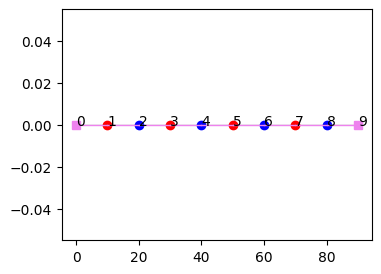

In [41]:
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )
 
print(y_opt)#, pe.value(rate[0]))
# print(path_prob)
# print(pe.value(ObjRule(model)))
model.objective.display()

y_opt = np.zeros(N)
for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += x_opt[user_pair,n1,t] 
        for n2 in n_list:
            sum1_const += x_opt[user_pair,n1,n2]
    if sum1_const>0.5:
        y_opt[n1] = 1
print(y_opt,np.sum(y_opt))


plot_output(x_opt,y_opt)       

# print(model.fidelity[0].value)

In [390]:
n_hop = 1
F_e2e = ((1+3*((4*F-1)/3)**n_hop)/4-0.5)
print(pe.value(ObjRule(model)),ent_calc_x(0,x_opt,w,Wmax = w)*F_e2e)
print(x_opt)
x0 = np.zeros((1,N,N))
x0[0,:,:] =np.diag(np.ones(N-1),1)
# x0[0,0,2] = 1
# x0[0,2,4] = 1
# print(x0)
n_hop = 2
F_e2e = ((1+3*((4*F-1)/3)**n_hop)/4-0.5)
print(ent_calc_x(0,x0,w,Wmax = w)*F_e2e)

# model = pe.ConcreteModel()

# model.R = pe.Set(initialize=R_list)
# model.N = pe.Set(initialize=range(N)) 
# model.C = pe.Set(initialize=range(C))
# model.matrix = model.C*model.N*model.N
# model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary,initialize=vec)
# model.y = pe.Var(model.R, domain=pe.Binary,initialize=0)
# # x0 = np.zeros((N,N))
# # for n1 in range(N):
# #     for n2 in range(N):
# #         x0[n1,n2] = pe.value(model.x[0,n1,n2])
# print(pe.value(ObjRule(model)))

0.10388225339239084 0.10388225339239084
[[[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
0.32007574721071347


In [96]:

p_opt = np.zeros((N,N))
x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in R_list:
    y_opt[i] = model.y[i].value

for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value
#             p_opt[i,j] = pe.value(path_prob[i][j])
print(x_opt)

[[[0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]]]


In [59]:
from pyomo.environ import *

model = ConcreteModel()

#Define the set
model.P = Set(initialize=['P1','P2','P3','P4'])

#Parameters
model.Beta = Param(model.P, initialize = {'P1':1,'P2':1.2,'P3':1.4,'P4':1.6})
model.Alpha = Param(model.P, initialize = {'P1':0.1,'P2':0.2,'P3':0.3,'P4':0.4})

#Variables
model.q = Var(model.P)

#Objective
def Payoff(model):
    return sum(Expr_if(IF=model.q[i]>=1, THEN=model.Beta[i] * log(model.q[i]),
              ELSE=(-0.5)*model.Alpha[i] * (model.q[i]-1)**2) for i in model.P)
model.payoff = Objective(expr = Payoff, sense = maximize)

#Constraints
def limit(model, i):
    return -1.1<= model.q[i]
model.limit = Constraint(model.P, rule = limit)

def balance(model):
    return summation(model.q) == 0
model.balance = Constraint(rule = balance)

# solver = SolverFactory('bonmin')
# solver.solve(model)
#model.pprint()
opt = pe.SolverFactory("ipopt",tee=True)
results = opt.solve(model)
results.write()

# print(model.payoff.value)          <--- printing value of objective function gives an error
# value(model.payoff)        <--- printing value of objective function gives an error

# payoff_ = 0
# for i in model.P:
#     if model.q[i].value>=1:
#         payoff_ +=  model.Beta[i] * log(model.q[i])
#     else:
#         payoff_ += (-0.5)*model.Alpha[i] * (model.q[i]-1)**2
# print(payoff_())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 4
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.12\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.02533888816833496
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


## Linear chain distance

In [704]:
# network graph
N = 17# number of nodes
# dist_list = np.arange(10,101,10)
dist_list = np.linspace(1,30,10)
num_rep = np.zeros(len(dist_list))
utility = np.zeros(len(dist_list))
rate_list = np.zeros(len(dist_list))
fidelity_list = np.zeros(len(dist_list))
node_list = np.arange(N)
for i_d, dist in enumerate(dist_list):
    G = nx.Graph()
    G.add_nodes_from(node_list)
    adj_mat = np.zeros((N,N))
    for n in range(N-1):
        adj_mat[n,n+1] = dist
    adj_mat += adj_mat.T

    pos = dict()
    for node in range(N):
        pos[node] = (p*node,0)

    G = nx.from_numpy_array(adj_mat)
#     plt.figure(figsize=(4,3))
#     nx.draw(G, pos = pos,  with_labels=True)
#     plt.show()

    ### minimum capacity

    Nmax = 2
    F = 0.95
    w = 1
    D0 = 3*w
    D = D0*np.ones(N)
    s_list = [0] # source
    t_list = [N-1] # destination

    C = len(s_list)
    R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))


    #Create a simple model
    model = pe.ConcreteModel()

    model.R = pe.Set(initialize=R_list)
    model.N = pe.Set(initialize=range(N)) 
    model.C = pe.Set(initialize=range(C))
    model.x = pe.Var(model.C,model.N,model.N, domain=pe.Binary)#,initialize=0)
    model.y = pe.Var(model.R, domain=pe.Binary)#,initialize=1)

    model.constraints = pe.ConstraintList()

    for n1 in R_list:
        n_list = np.array(list(set(R_list)-{n1}))
        sum1_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum1_const += model.x[user_pair,n1,t] 
            for n2 in n_list:
                sum1_const += w*model.x[user_pair,n1,n2]
        model.constraints.add( sum1_const <= D[n1]*model.y[n1] )

    path_length = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]

        for n1 in range(N):
            model.constraints.add(  model.x[user_pair,n1,n1] == 0 ) 
            model.constraints.add(  model.x[user_pair,n1,s] == 0 ) 
            model.constraints.add(  model.x[user_pair,t,n1] == 0 ) 

        for n1 in R_list:

    #         if nx.has_path(G, source=s, target=n1):
    #             l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
    #             path_length += l_uv*  model.x[user_pair,s,n1]

    #         if nx.has_path(G, source=n1, target=t):
    #             l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
    #             path_length += l_uv* model.x[user_pair,n1,t]

            path = model.x[user_pair,n1,t] - model.x[user_pair,s,n1]
            for n2 in R_list:
                if n2 != n1:
                    path += model.x[user_pair,n1,n2] - model.x[user_pair,n2,n1]
    #                 if nx.has_path(G, source=n1, target=n2):
    #                     l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
    #                     path_length += l_uv* model.x[user_pair,n1,n2]

            model.constraints.add( path == 0 ) 
        model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,s,i] for i in model.R) == 1)
        model.constraints.add( expr= model.x[user_pair,s,t] + sum(model.x[user_pair,i,t] for i in model.R) == 1)


    ###########
    η = 1.0
    model.minCapacity = pe.Var(model.C,domain=pe.NonNegativeReals)
    model.fidelity = pe.Var(model.C)#,domain=pe.NonNegativeReals)
    # fidelity = [0]*C
    # def ObjRule(model):
    #     fidelity = [None]*C
    # utility = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]

        for n1 in (R_list):
            p_k= η* (10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) )
            model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,s,n1] )
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
            model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,n1,t] )
            for n2 in (R_list):
                if n2 != n1:
                    p_k= η* (10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) )
                    model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,n1,n2] )

        p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=t, weight="weight")/10) 
        model.constraints.add(model.minCapacity[user_pair] <=  p_k**model.x[user_pair,s,t] )



        number =  model.x[user_pair,s,t]+ sum(model.x[user_pair,s,i]+model.x[user_pair,i,t] for i in model.R)
        for n1 in list(R_list):
            n_list = np.array(list(set(R_list)-{n1}))
            number += sum(model.x[user_pair,n1,i] for i in n_list)
    #     fidelity[user_pair] = 3*((4*F-1)/3)**number-1
    #         number += sum(model.x[user_pair,n1,i] for i in n_list)
        model.constraints.add( model.fidelity[user_pair] == 3*((4*F-1)/3)**number-1)
    # #         utility += -pe.log( ((1+3*((4*F-1)/3)**number)/4-0.5)*model.minCapacity[user_pair]*w )
    #     utility += -pe.log( model.minCapacity[user_pair]*w )
    #     return utility
    #################
#     model.constraints.add(expr= sum(model.y[i] for i in model.R) <= Nmax)
    # model.objective = pe.Objective(rule=ObjRule, sense=pe.maximize)
    model.objective = pe.Objective(expr= sum(pe.log(model.minCapacity[i]* model.fidelity[i]) for i in model.C), sense=pe.maximize)
    # α = 1e-2
    # model.objective = pe.Objective(expr= (sum(pe.log(model.minCapacity[i]*fidelity[i]) for i in model.C) - α* path_length), sense=pe.maximize)
    # model.objective = pe.Objective(expr= model.minCapacity[0]*fidelity[0] , sense=pe.maximize)

    opt = pe.SolverFactory("couenne",tee=True)
    results = opt.solve(model)
    # results.write()
    # model.objective.display()
    # model.display()
    # model.pprint()
    
    x_opt = np.zeros((C,N,N))
    # for i in R_list:
    #     y_opt[i] = model.y[i].value

    for i in range(N):
        for j in range(N):
            for user_pair in range(C):
                x_opt[user_pair,i,j] =  model.x[user_pair,i,j].value

    y_opt = np.zeros(N)
    for n1 in R_list:
        n_list = np.array(list(set(R_list)-{n1}))
        sum1_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum1_const += x_opt[user_pair,n1,t] 
            for n2 in n_list:
                sum1_const += x_opt[user_pair,n1,n2]
        if sum1_const>0.5:
            y_opt[n1] = 1

    num_rep[i_d] = np.sum(y_opt)
    utility[i_d] = model.objective()
    rate_list[i_d] = model.minCapacity[0].value
    fidelity_list[i_d] = model.fidelity[0].value
#     plot_output(x_opt,y_opt)       
#     for user_pair in range(C):
#         s = s_list[user_pair]
#         t = t_list[user_pair]
#     #     print("optimal memory for ", (s,t)," :", model.w[user_pair].value)#, pe.value(rate[user_pair]) )

# #     print(y_opt)#, pe.value(rate[0]))
#     # print(path_prob)
#     # print(pe.value(ObjRule(model)))
#     model.objective.display()

    # print(model.fidelity[0].value)

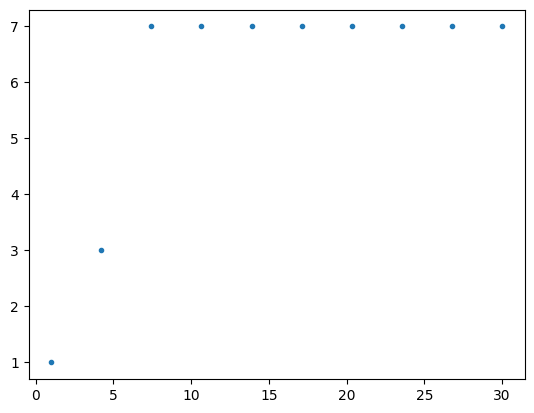

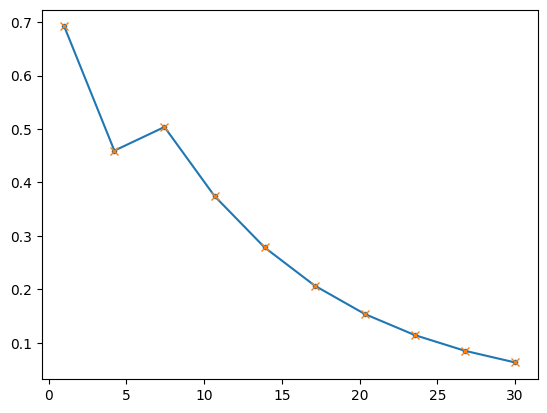

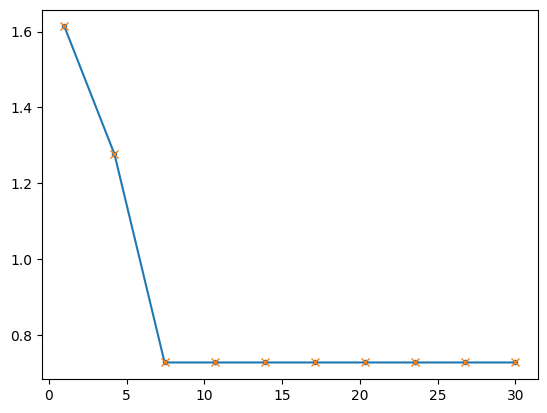

In [706]:
plt.plot(dist_list,num_rep,".")
plt.show()

plt.plot(dist_list,rate_couenne,".-")
plt.plot(dist_list,rate_baron,"x")
# plt.plot(dist_list,utility,".-")
plt.show()

plt.plot(dist_list,fidelity_couenne,".-")
plt.plot(dist_list,fidelity_baron,"x")
# plt.plot(dist_list,utility,".-")
plt.show()

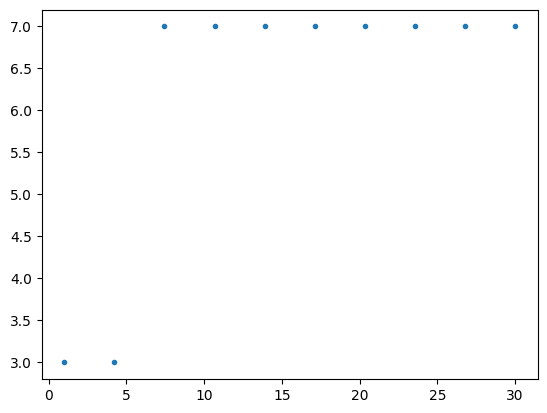

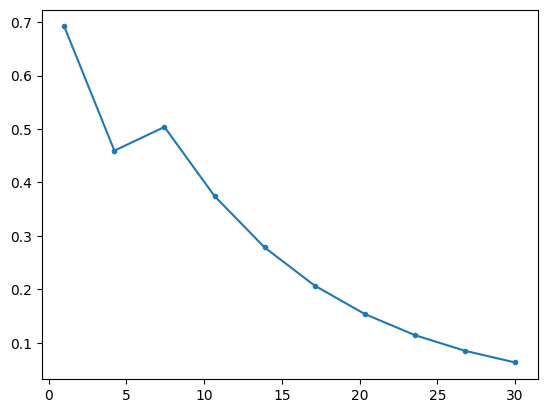

In [671]:
plt.plot(dist_list,num_rep,".")
plt.show()

plt.plot(dist_list,rate_list,".-")
# plt.plot(dist_list,utility,".-")
plt.show()

In [705]:
rate_couenne = np.copy(rate_list)
fidelity_couenne = np.copy(fidelity_list)

# rate_baron = np.copy(rate_list)
# fidelity_baron = np.copy(fidelity_list)

In [697]:
dist_list = np.linspace(1,30,10)
dist_list[4]

13.88888888888889